In [ ]:
# 掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


index：日期
input data：批發市場交易量、每日天氣、颱風警報
output answer：批發市場每日交易價格

In [ ]:
import pandas as pd
from IPython.display import display
# 資料來自Ai團專_農時_共享資料夾，事先要先將 共享資料夾的捷徑加入自己的雲端硬碟內
w_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/氣候資料/各縣市氣候資料_0701/dataset.csv'
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/市場批發交易歷史資料/Banana.csv'
weather_df = pd.read_csv(w_file_path) # 氣候資料
weather_df.set_index(["date"], inplace=True)
price_df = pd.read_csv(p_file_path) # 香蕉的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
display(weather_df.tail())
display(price_df.tail())


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city_KLU,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMaxTime_KLU,StnPresMin_KLU,StnPresMinTime_KLU,Temperature_KLU,TMax_KLU,TMaxTime_KLU,TMin_KLU,TMinTime_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,RHMinTime_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,WGustTime_KLU,Precp_KLU,PrecpHour_KLU,PrecpMax10_KLU,PrecpMax10Time_KLU,PrecpMax60_KLU,PrecpMax60Time_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,UVIMax_KLU,UVIMaxTime_KLU,CloudAmount_KLU,city_TPE,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMaxTime_TPE,...,EvapA_HWA,UVIMax_HWA,UVIMaxTime_HWA,CloudAmount_HWA,city_TTT,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMaxTime_TTT,StnPresMin_TTT,StnPresMinTime_TTT,Temperature_TTT,TMax_TTT,TMaxTime_TTT,TMin_TTT,TMinTime_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,RHMinTime_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,WGustTime_TTT,Precp_TTT,PrecpHour_TTT,PrecpMax10_TTT,PrecpMax10Time_TTT,PrecpMax60_TTT,PrecpMax60Time_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,UVIMax_TTT,UVIMaxTime_TTT,CloudAmount_TTT,WarnMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,基隆市,997.3,1005.4,999.9,2021-06-14 00:01:00,995.3,2021-06-14 15:33:00,29.6,34.1,2021-06-14 14:15:45,27.3,2021-06-14 03:40:30,26.1,79.8,58.8,2021-06-14 12:36:45,4.7,173.2,13.6,253.0,2021-06-14 10:10:15,0.0,0.0,0.0,NaN,0.0,NaN,8.7,63.7,24.9,31.0,7.4,13.0,2021-06-14 13:00:00,7.5,臺北市,978.9,1164.5,981.5,2021-06-14 03:00:42,...,5.2,13.0,2021-06-14 12:00:00,4.1,臺東縣,966.7,1005.6,969.3,2021-06-14 00:01:25,964.9,2021-06-14 16:40:08,27.2,31.5,2021-06-14 12:35:50,23.8,2021-06-14 04:34:13,25.7,83.9,62.6,2021-06-14 11:24:30,1.6,139.8,7.4,172.0,2021-06-14 13:48:07,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.8,26.8,23.5,5.8,13.3,2021-06-14 12:40:00,4.5,0
2021-06-15,基隆市,994.7,1002.9,995.9,2021-06-15 00:01:00,993.5,2021-06-15 12:51:00,30.2,33.5,2021-06-15 13:34:45,27.6,2021-06-15 08:42:00,26.0,76.2,62.8,2021-06-15 11:08:00,6.1,231.2,16.5,253.0,2021-06-15 06:39:15,0.0,0.0,0.0,NaN,0.0,NaN,10.9,79.5,27.3,30.6,7.9,13.0,2021-06-15 12:00:00,7.2,臺北市,976.6,1156.6,977.9,2021-06-15 08:28:14,...,6.7,13.0,2021-06-15 13:00:00,4.1,臺東縣,964.6,1003.2,966.3,2021-06-15 12:02:27,963.3,2021-06-15 10:16:10,27.5,32.1,2021-06-15 11:59:22,24.2,2021-06-15 08:52:37,25.4,79.9,59.2,2021-06-15 10:56:33,2.0,148.6,9.4,166.6,2021-06-15 11:59:30,0.0,0.0,0.0,NaN,0.0,NaN,10.6,78.2,26.0,25.3,6.2,12.7,2021-06-15 12:00:00,5.2,0
2021-06-16,基隆市,995.4,1003.5,997.0,2021-06-16 21:56:30,993.4,2021-06-16 02:18:00,31.0,34.4,2021-06-16 15:19:15,27.7,2021-06-16 02:22:45,25.1,68.8,53.5,2021-06-16 15:40:00,8.7,248.8,20.4,260.2,2021-06-16 13:01:15,0.0,0.0,0.0,NaN,0.0,NaN,11.5,84.2,28.6,29.6,10.3,14.0,2021-06-16 12:00:00,2.8,臺北市,977.7,1161.4,979.4,2021-06-16 18:40:42,...,7.7,13.0,2021-06-16 12:00:00,1.9,臺東縣,965.4,1004.2,967.5,2021-06-16 21:56:45,963.5,2021-06-16 05:06:48,28.3,33.2,2021-06-16 12:44:23,24.1,2021-06-16 03:53:27,24.4,72.7,51.6,2021-06-16 13:24:10,2.3,166.5,10.4,194.7,2021-06-16 12:31:57,0.0,0.0,0.0,NaN,0.0,NaN,10.8,79.8,27.8,24.1,7.4,13.0,2021-06-16 12:20:00,4.4,0
2021-06-17,基隆市,996.9,1005.0,998.2,2021-06-17 08:58:15,995.5,2021-06-17 09:14:45,31.1,35.2,2021-06-17 13:44:00,28.0,2021-06-17 05:22:45,25.3,68.8,54.8,2021-06-17 14:04:00,7.9,233.2,18.1,243.2,2021-06-17 06:48:15,0.0,0.0,0.0,NaN,0.0,NaN,11.1,81.3,26.2,23.9,8.6,13.0,2021-06-17 12:00:00,5.8,臺北市,979.0,1166.5,980.5,2021-06-17 08:18:46,...,6.1,13.0,2021-06-17 12:00:00,1.5,臺東縣,966.8,1005.4,968.2,2021-06-17 20:23:43,965.5,2021-06-17 14:22:05,28.4,33.0,2021-06-17 12:45:47,24.9,2021-06-17 10:27:33,24.5,72.5,52.4,2021-06-17 12:09:22,2.0,164.5,9.0,151.5,2021-06-17 14:03:52,0.0,0.0,0.0,NaN,0.0,NaN,10.2,75.2,27.2,25.0,7.2,13.0,2021-06-17 12:00:00,2.5,0
2021-06-18,基隆市,995.5,1003.6,997.1,2021-06-18 03:47:30,993.5,2021-06-18 15:39:30,31.3,35.4,2021-06-18 13:46:15,28.4,2021-06-18 03:33:15,25.4,68.0,50.5,2021-06-18 13:44:45,8.0,232.5,18.7,239.8,2021-06-18 07:33:30,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.5,26.6,25.8,9.2,14.0,2021-06-18 12:00:0

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
Date,,,,,,,,,,,
2021-06-15,台北一,A1 香蕉,NaN,NaN,NaN,NaN,NaN,6,2,2021,1
2021-06-16,台北一,A1 香蕉,NaN,NaN,NaN,NaN,NaN,6,3,2021,1
2021-06-17,台北一,A1 香蕉,32.5,23.4,13.3,23.2,18276.0,6,4,2021,0
2021-06-18,台北一,A1 香蕉,30.9,20.4,12.1,20.9,14040.0,6,5,2021,0
2021-06-19,台北一,A1 香蕉,33.4,25.5,14.0,24.8,13485.0,6,6,2021,0


先處理市場批發交易資料：Date、Market、product、Up_price、Mid_price、Low_price、	Avg_price、Volume、Month、Week_day、Year、Rest_day。


---
* 抓出不含休市資料的表格（使用loc不用drop）
* 加入前7天的市場交易資訊（不包含休市了，因此若中間日期有休市日會自動跳過）
* 加入累積7天平均交易資訊
* 加入要預測日的均價（3天後的均價）



In [ ]:
# 將市場資料中的
filter = price_df.Rest_day == 0 # 休市日標記為0
indexNames = price_df[filter].index # 符合filter的index們
newprice_df = price_df.loc[indexNames,:] # 使用新的df
newprice_df.Rest_day.value_counts() # 休市日部分只剩下標注為0的資料了

0    6500
Name: Rest_day, dtype: int64

In [ ]:
# 加入前6天的交易資訊
for day in range(1, 7):
  columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
  temp_df = newprice_df.loc[:, columns]
  shifted_df=temp_df.shift(periods=day)
  shifted_df = shifted_df.add_suffix('_' + str(day) + 'days_ago')
  newprice_df = pd.merge(newprice_df, shifted_df, how='outer', left_index=True, right_index=True)
newprice_df

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-02,台北一,A1 香蕉,30.0,22.0,14.0,20.2,22319.0,1,7,2000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,台北一,A1 香蕉,26.0,18.0,12.0,19.5,15810.0,1,1,2000,0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,台北一,A1 香蕉,28.0,18.0,12.0,20.3,15126.0,1,2,2000,0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,台北一,A1 香蕉,28.0,20.0,10.0,20.0,18693.0,1,3,2000,0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,台北一,A1 香蕉,28.0,20.0,10.0,20.3,22677.0,1,4,2000,0,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,台北一,A1 香蕉,34.1,25.6,19.8,26.1,15004.0,6,7,2021,0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,29.7,23.5,16.5,23.3,14807.0
2021-06-14,台北一,A1 香蕉,33.3,26.6,19.8,26.6,15039.0,6,1,2021,0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0
2021-06-17,台北一,A1 香蕉,32.5,23.4,13.3,23.2,18276.0,6,4,2021,0,33.3,26.6,19.8,26.6,15039.0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0


In [ ]:
# 加入過去一周價格資料的平均
# 方法二，把上面找到的資料加起來做平均
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  display(temp_df)
  newprice_df[c + '_mean'] = temp_df.mean(axis=1)
newprice_df.tail()

In [ ]:
# 要預測的答案為3天後的價格，因此把3天後的價格加入
shifted_df=newprice_df.Avg_price.shift(periods=-3)
newprice_df['ans_price'] = shifted_df
newprice_df.loc[:,['Avg_price', 'ans_price']].tail(10)

,Avg_price,ans_price
Date,,
2021-06-08,24.4,25.1
2021-06-09,23.5,25.3
2021-06-10,25.8,26.1
2021-06-11,25.1,26.6
2021-06-12,25.3,23.2
2021-06-13,26.1,20.9
2021-06-14,26.6,24.8
2021-06-17,23.2,NaN
2021-06-18,20.9,NaN


In [ ]:
# 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# 縣市只挑選香蕉主要產地：高雄、屏東、南投、台南、台中、彰化、台東 7個縣市
factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
citys = ['KHH', 'IUH', 'NTO', 'TXG', 'CWH', 'TNN', 'TTT']
keep = ['WarnMark']
for c in citys:
  for w in weather_df:
    if c in w:
      for f in factors:
        if f in w:
          keep.append(w)
weather_df = weather_df.loc[:, keep]
weather_df.tail()

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0
2021-06-15,0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7,26.3,2.3,8.4,0.2,29.7,2.1,7.7,0.5,28.9,1.5,6.7,4.8,27.5,2.0,9.4,0.0
2021-06-16,0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2,25.0,2.2,9.4,16.0,28.3,2.0,7.3,17.8,27.9,1.6,7.9,26.6,28.3,2.3,10.4,0.0
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0


In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean(O)
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'Temperature' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_mean_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].mean(axis=0)
  d = d.add_suffix('_mean_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max(O)
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'T_Max' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_max_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].max(axis=0)
  d = d.add_suffix('_max_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min(O)
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'T_Min' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_min_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].min(axis=0)
  d = d.add_suffix('_min_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum(O)
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'Precp_' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_sum_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].sum(axis=0)
  d = d.add_suffix('_sum_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
display(weather_df.head())
display(weather_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0,22.0,1.9,8.3,0.0,21.3,1.6,8.9,0.0,9.0,7.5,14.1,0.0,19.3,3.6,10.0,0.0,19.3,2.538,8.883,0.0,19.5,2.3,11.1,0.0,19.2,1.8,7.2,0.0,20.5303,20.6629,7.78876,16.9404,16.9404,18.2584,17.1427,101.8,77,350.5,475.6,148,38.8,206.8
2000-01-02,0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,18.7,4.0,13.4,0.0,18.7,2.115,9.306,0.0,18.6,1.6,8.5,0.0,17.9,2.8,11.4,0.0,20.5506,20.6764,7.81573,16.964,16.964,18.2876,17.1326,101.8,77,350.5,475.6,148,38.8,206.9
2000-01-03,0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,18.2,2.1,13.5,0.0,18.2,2.679,14.241,0.0,18.3,1.4,6.9,0.0,16.9,2.2,9.8,0.0,20.5978,20.7045,7.83708,17.0169,17.0169,18.3472,17.1506,101.8,78.9,350.5,475.6,148,38.8,212.3
2000-01-04,0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,17.5,1.6,7.2,0.0,17.5,2.538,13.677,0.0,17.7,1.6,6.1,0.2,17.2,1.5,5.9,0.0,20.6494,20.7506,7.8764,17.0663,17.0663,18.3989,17.1944,145.6,88.9,425.9,540.5,204,92.6,225.5
2000-01-05,0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,18.8,1.7,10.8,0.0,18.8,2.256,11.280,0.0,19.8,1.3,6.1,0.2,19.5,1.4,7.3,0.2,20.7067,20.8022,7.94045,17.1236,17.1236,18.4719,17.2472,145.5,89.1,426,540.5,204,92.4,227.7


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0,28.36,27.52,22.16,25.96,29.38,28.64,27.96,51.9,45,19.2,17.3,20.5,44.3,0
2021-06-15,0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7,26.3,2.3,8.4,0.2,29.7,2.1,7.7,0.5,28.9,1.5,6.7,4.8,27.5,2.0,9.4,0.0,28.1,27.35,22.05,25.95,29.35,28.45,28.15,51.8,44.6,18.8,17.1,20.5,44.3,0
2021-06-16,0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2,25.0,2.2,9.4,16.0,28.3,2.0,7.3,17.8,27.9,1.6,7.9,26.6,28.3,2.3,10.4,0.0,27.8,27.2333,21.8,25.8333,29.2333,28.3,28.3667,46.6,39.7,18.1,16.9,20,39.5,0
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0,28.05,27.55,22.1,26.25,29.7,28.5,28.4,19.9,9.6,5.9,0.9,2.2,12.9,0
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0,28.2,27.7,22.3,26.3,29.9,28.9,28.4,10.9,4.3,1.4,0.7,2.1,4,0


In [ ]:
# 合併 天氣因素表格&批發市場價格表格
# how的部分改為inner，因為價格部分不是每天都有，變成以兩個表格都有的資料再做合併
new_df = pd.merge(weather_df, newprice_df, how='inner', left_index=True, right_index=True) 
display(new_df.head())
display(new_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Month,Week_day,Year,Rest_day,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2000-01-02,0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,18.7,4.0,13.4,0.0,18.7,2.115,9.306,0.0,18.6,1.6,8.5,0.0,17.9,2.8,11.4,0.0,20.5506,20.6764,7.81573,16.964,16.964,18.2876,17.1326,101.8,77,350.5,475.6,...,1,7,2000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,22.000000,14.000000,20.20,22319.000000,20.0
2000-01-03,0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,18.2,2.1,13.5,0.0,18.2,2.679,14.241,0.0,18.3,1.4,6.9,0.0,16.9,2.2,9.8,0.0,20.5978,20.7045,7.83708,17.0169,17.0169,18.3472,17.1506,101.8,78.9,350.5,475.6,...,1,1,2000,0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,20.000000,13.000000,19.85,19064.500000,20.3
2000-01-04,0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,17.5,1.6,7.2,0.0,17.5,2.538,13.677,0.0,17.7,1.6,6.1,0.2,17.2,1.5,5.9,0.0,20.6494,20.7506,7.8764,17.0663,17.0663,18.3989,17.1944,145.6,88.9,425.9,540.5,...,1,2,2000,0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.333333,12.666667,20.00,17751.666667,20.2
2000-01-05,0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,18.8,1.7,10.8,0.0,18.8,2.256,11.280,0.0,19.8,1.3,6.1,0.2,19.5,1.4,7.3,0.2,20.7067,20.8022,7.94045,17.1236,17.1236,18.4719,17.2472,145.5,89.1,426,540.5,...,1,3,2000,0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.500000,12.000000,20.00,17987.000000,19.6
2000-01-06,0,21.9,1.2,4.9,0.1,21.9,2.4,10.1,1.6,7.1,4.8,12.0,0.0,19.7,3.1,12.5,0.0,19.7,1.551,9.306,0.0,20.2,1.2,5.3,0.0,18.5,2.0,8.7,3.2,20.7494,20.8371,7.98202,17.1663,17.1663,18.5292,17.2674,145.4,89.2,429.1,550.2,...,1,4,2000,0,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.600000,11.600000,20.06,18925.000000,20.1


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Month,Week_day,Year,Rest_day,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2021-06-12,0,28.9,1.6,9.3,9.6,27.5,1.8,9.1,6.5,21.9,1.5,8.4,22.1,25.2,1.4,8.5,18.3,28.7,1.4,10.5,16.9,28.4,1.4,8.3,12.4,26.0,1.1,6.0,6.3,28.5571,27.5857,22.1143,25.8,29.2571,28.7,27.4714,71.9,59,51.5,36.6,...,6,6,2021,0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,29.7,23.5,16.5,23.3,14807.0,29.6,23.8,16.0,23.4,18278.0,32.500000,24.357143,16.414286,24.400000,17779.714286,23.2
2021-06-13,0,29.2,1.5,6.9,10.4,28.0,1.4,6.8,7.5,22.1,1.6,7.7,10.2,25.6,1.7,7.3,1.0,29.2,1.4,6.3,0.0,29.3,1.4,6.9,4.0,26.5,1.1,6.3,2.5,28.5,27.6,22.15,25.9,29.35,28.75,27.7167,62.3,52.5,29.4,18.3,...,6,7,2021,0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,29.7,23.5,16.5,23.3,14807.0,33.142857,24.614286,16.957143,24.785714,17312.000000,20.9
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0,28.36,27.52,22.16,25.96,29.38,28.64,27.96,51.9,45,19.2,17.3,...,6,1,2021,0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,33.657143,25.057143,17.428571,25.257143,17345.142857,24.8
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0,28.05,27.55,22.1,26.25,29.7,28.5,28.4,19.9,9.6,5.9,0.9,...,6,4,2021,0,33.3,26.6,19.8,26.6,15039.0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,33.757143,24.971429,16.714286,25.085714,17457.428571,NaN
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0,28.2,27.7,22.3,26.3,29.9,28.9,28.4,10.9,4.3,1.4,0.7,...,6,5,2021,0,32.5,23.4,13.3,23.2,18276.0,33.3,26.6,19.8,26.6,15039.0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,33.557143,24.585714,16.185714,24.714286,16475.857143,NaN


In [ ]:
# 尋找空值
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

Avg_price_6days_ago    6
Low_price_6days_ago    6
Mid_price_6days_ago    6
Up_price_6days_ago     6
Volume_6days_ago       6
Volume_5days_ago       5
Avg_price_5days_ago    5
Low_price_5days_ago    5
Mid_price_5days_ago    5
Up_price_5days_ago     5
Up_price_4days_ago     4
Low_price_4days_ago    4
Mid_price_4days_ago    4
Volume_4days_ago       4
Avg_price_4days_ago    4
Volume_3days_ago       3
Avg_price_3days_ago    3
Low_price_3days_ago    3
Mid_price_3days_ago    3
Up_price_3days_ago     3
Low_price_2days_ago    2
Up_price_2days_ago     2
Mid_price_2days_ago    2
ans_price              2
Avg_price_2days_ago    2
Volume_2days_ago       2
Volume_1days_ago       1
Avg_price_1days_ago    1
Low_price_1days_ago    1
Mid_price_1days_ago    1
Up_price_1days_ago     1
dtype: int64

In [ ]:
# 另外因為只有針對單一市場跟作物，因此不需要 Market 跟 Product 兩個欄位了，使用drop方式移除，然後也不需要rest day了
new_df = new_df.drop(columns=['Market', 'Product', 'Rest_day'], axis=1)
display(new_df.head())
display(new_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2000-01-02,0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,18.7,4.0,13.4,0.0,18.7,2.115,9.306,0.0,18.6,1.6,8.5,0.0,17.9,2.8,11.4,0.0,20.5506,20.6764,7.81573,16.964,16.964,18.2876,17.1326,101.8,77,350.5,475.6,...,22319.0,1,7,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,22.000000,14.000000,20.20,22319.000000,20.0
2000-01-03,0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,18.2,2.1,13.5,0.0,18.2,2.679,14.241,0.0,18.3,1.4,6.9,0.0,16.9,2.2,9.8,0.0,20.5978,20.7045,7.83708,17.0169,17.0169,18.3472,17.1506,101.8,78.9,350.5,475.6,...,15810.0,1,1,2000,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,20.000000,13.000000,19.85,19064.500000,20.3
2000-01-04,0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,17.5,1.6,7.2,0.0,17.5,2.538,13.677,0.0,17.7,1.6,6.1,0.2,17.2,1.5,5.9,0.0,20.6494,20.7506,7.8764,17.0663,17.0663,18.3989,17.1944,145.6,88.9,425.9,540.5,...,15126.0,1,2,2000,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.333333,12.666667,20.00,17751.666667,20.2
2000-01-05,0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,18.8,1.7,10.8,0.0,18.8,2.256,11.280,0.0,19.8,1.3,6.1,0.2,19.5,1.4,7.3,0.2,20.7067,20.8022,7.94045,17.1236,17.1236,18.4719,17.2472,145.5,89.1,426,540.5,...,18693.0,1,3,2000,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.500000,12.000000,20.00,17987.000000,19.6
2000-01-06,0,21.9,1.2,4.9,0.1,21.9,2.4,10.1,1.6,7.1,4.8,12.0,0.0,19.7,3.1,12.5,0.0,19.7,1.551,9.306,0.0,20.2,1.2,5.3,0.0,18.5,2.0,8.7,3.2,20.7494,20.8371,7.98202,17.1663,17.1663,18.5292,17.2674,145.4,89.2,429.1,550.2,...,22677.0,1,4,2000,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,19.600000,11.600000,20.06,18925.000000,20.1


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2021-06-12,0,28.9,1.6,9.3,9.6,27.5,1.8,9.1,6.5,21.9,1.5,8.4,22.1,25.2,1.4,8.5,18.3,28.7,1.4,10.5,16.9,28.4,1.4,8.3,12.4,26.0,1.1,6.0,6.3,28.5571,27.5857,22.1143,25.8,29.2571,28.7,27.4714,71.9,59,51.5,36.6,...,15720.0,6,6,2021,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,29.7,23.5,16.5,23.3,14807.0,29.6,23.8,16.0,23.4,18278.0,32.500000,24.357143,16.414286,24.400000,17779.714286,23.2
2021-06-13,0,29.2,1.5,6.9,10.4,28.0,1.4,6.8,7.5,22.1,1.6,7.7,10.2,25.6,1.7,7.3,1.0,29.2,1.4,6.3,0.0,29.3,1.4,6.9,4.0,26.5,1.1,6.3,2.5,28.5,27.6,22.15,25.9,29.35,28.75,27.7167,62.3,52.5,29.4,18.3,...,15004.0,6,7,2021,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,29.7,23.5,16.5,23.3,14807.0,33.142857,24.614286,16.957143,24.785714,17312.000000,20.9
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0,28.36,27.52,22.16,25.96,29.38,28.64,27.96,51.9,45,19.2,17.3,...,15039.0,6,1,2021,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,31.8,24.0,18.3,24.4,17490.0,33.657143,25.057143,17.428571,25.257143,17345.142857,24.8
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0,28.05,27.55,22.1,26.25,29.7,28.5,28.4,19.9,9.6,5.9,0.9,...,18276.0,6,4,2021,33.3,26.6,19.8,26.6,15039.0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,32.3,23.1,15.8,23.5,20911.0,33.757143,24.971429,16.714286,25.085714,17457.428571,NaN
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0,28.2,27.7,22.3,26.3,29.9,28.9,28.4,10.9,4.3,1.4,0.7,...,14040.0,6,5,2021,32.5,23.4,13.3,23.2,18276.0,33.3,26.6,19.8,26.6,15039.0,34.1,25.6,19.8,26.1,15004.0,34.4,25.4,15.8,25.3,15720.0,35.1,25.2,14.9,25.1,18309.0,34.6,25.5,17.6,25.8,18943.0,33.557143,24.585714,16.185714,24.714286,16475.857143,NaN


In [ ]:
# 前後有空值，因此只取中間段
new_df = new_df[6:-3]
# display(new_df.head())
# display(new_df.tail())

In [ ]:
# 尋找空值，要無空值才是正常
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [ ]:
# 先將跨模組的驗證資料切割出來，以2020-06-01以後的資料作為 測試資料
test_df = new_df.loc['2020-06-01':,:] # 測試資料
merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
display(merge_df.tail())
display(test_df.head())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2020-06-02,0,29.3,1.5,6.9,0.1,28.2,1.8,7.2,0.0,21.8,1.8,9.1,1.1,26.2,1.8,7.8,0.0,29.2,1.6,7.7,0.0,29.2,1.4,6.8,0.0,26.9,1.4,6.8,0.0,28.8135,27.7146,21.8742,26.2022,29.518,28.8034,26.9371,920.3,931.8,659.2,463.1,...,17534.0,6,2,2020,38.9,32.7,23.5,32.1,12735.0,36.9,30.8,21.9,30.2,12256.0,33.0,27.8,16.3,26.5,11119.0,34.1,27.9,20.3,27.6,13500.0,36.5,28.7,20.4,28.6,17364.0,35.1,25.7,15.0,25.4,19064.0,35.985714,29.100000,19.542857,28.542857,14796.000000,28.6
2020-06-03,0,29.3,1.6,7.0,0.0,28.0,2.3,9.6,0.0,21.4,2.3,8.1,0.0,26.3,2.3,9.2,0.0,29.3,1.9,7.7,0.0,29.3,1.5,6.3,0.0,27.5,1.7,8.2,0.0,28.8045,27.7034,21.8798,26.2022,29.518,28.7933,26.9315,925.7,950.1,659.8,465.5,...,15934.0,6,3,2020,37.4,30.1,19.4,29.4,17534.0,38.9,32.7,23.5,32.1,12735.0,36.9,30.8,21.9,30.2,12256.0,33.0,27.8,16.3,26.5,11119.0,34.1,27.9,20.3,27.6,13500.0,36.5,28.7,20.4,28.6,17364.0,35.971429,29.614286,20.500000,29.042857,14348.857143,28.1
2020-06-04,0,29.5,1.5,6.9,0.0,28.3,2.6,10.3,0.0,21.7,2.1,8.1,0.0,26.6,2.2,8.3,0.0,29.5,1.9,7.7,0.0,29.4,1.3,6.3,0.0,27.4,1.9,7.4,0.0,28.782,27.691,21.8865,26.1955,29.5146,28.773,26.9157,937.9,956.9,663.9,468.7,...,17555.0,6,4,2020,35.0,29.3,21.7,28.9,15934.0,37.4,30.1,19.4,29.4,17534.0,38.9,32.7,23.5,32.1,12735.0,36.9,30.8,21.9,30.2,12256.0,33.0,27.8,16.3,26.5,11119.0,34.1,27.9,20.3,27.6,13500.0,35.757143,29.600000,20.914286,29.071429,14376.142857,24.6
2020-06-05,0,29.1,1.2,7.1,1.5,27.9,1.9,9.0,1.9,21.6,2.4,9.5,2.2,26.6,2.2,9.5,1.2,29.8,2.1,9.3,0.0,29.1,1.6,7.5,0.4,27.4,1.8,7.8,0.0,28.7697,27.6809,21.8921,26.1865,29.5112,28.7629,26.9067,937.9,957,664,469,...,17845.0,6,5,2020,35.0,28.6,23.3,28.8,17555.0,35.0,29.3,21.7,28.9,15934.0,37.4,30.1,19.4,29.4,17534.0,38.9,32.7,23.5,32.1,12735.0,36.9,30.8,21.9,30.2,12256.0,33.0,27.8,16.3,26.5,11119.0,35.871429,29.685714,21.271429,29.214286,14996.857143,23.0
2020-06-06,0,28.2,1.3,8.6,18.2,27.4,2.0,10.9,9.5,20.4,2.7,12.3,16.7,25.9,2.5,11.0,7.5,29.0,2.2,10.5,1.5,28.5,1.7,8.7,10.4,27.5,1.8,10.5,0.7,28.7674,27.6787,21.9022,26.1888,29.5135,28.764,26.9112,944.2,965.3,666.9,472.3,...,23672.0,6,6,2020,34.9,28.5,22.8,28.6,17845.0,35.0,28.6,23.3,28.8,17555.0,35.0,29.3,21.7,28.9,15934.0,37.4,30.1,19.4,29.4,17534.0,38.9,32.7,23.5,32.1,12735.0,36.9,30.8,21.9,30.2,12256.0,36.142857,29.785714,21.785714,29.442857,16790.142857,22.8


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2000-01-08,0,20.5,2.0,7.3,0.0,21.4,2.0,8.5,0.0,10.4,5.5,4.9,0.0,18.1,3.1,9.9,0.0,18.1,1.692,9.870,0.0,18.9,1.6,8.8,0.0,18.5,1.9,7.7,0.0,20.8393,20.8955,8.03483,17.2101,17.2101,18.6146,17.3213,162,101.8,450.2,569.8,...,31827.0,1,6,2000,30.0,21.0,14.0,20.2,17200.0,28.0,20.0,10.0,20.3,22677.0,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,30.0,22.0,14.0,20.2,22319.0,28.571429,20.000000,12.285714,20.014286,20521.714286,18.1
2000-01-10,0,23.7,1.5,7.3,0.0,23.1,3.7,14.0,0.0,10.1,4.9,4.8,0.0,20.5,3.8,11.3,0.0,20.5,1.833,9.729,0.0,21.7,1.8,6.8,0.0,19.8,2.7,11.7,0.1,20.9022,20.9225,8.03371,17.2449,17.2449,18.6775,17.3202,162.1,102.7,452,570.7,...,19699.0,1,1,2000,30.0,21.0,14.0,19.6,31827.0,30.0,21.0,14.0,20.2,17200.0,28.0,20.0,10.0,20.3,22677.0,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,26.0,18.0,12.0,19.5,15810.0,28.285714,19.714286,11.714286,20.000000,20147.428571,17.4
2000-01-11,0,22.2,1.8,6.7,0.1,22.6,3.0,13.8,0.4,10.5,5.0,5.3,0.0,19.9,2.1,7.4,0.0,19.9,1.410,5.781,0.0,20.0,1.3,6.3,0.2,19.7,1.9,8.2,0.6,20.9247,20.9371,8.05169,17.2663,17.2663,18.7022,17.327,162.1,103.6,452,570.7,...,24127.0,1,2,2000,28.0,20.0,10.0,20.1,19699.0,30.0,21.0,14.0,19.6,31827.0,30.0,21.0,14.0,20.2,17200.0,28.0,20.0,10.0,20.3,22677.0,28.0,20.0,10.0,20.0,18693.0,28.0,18.0,12.0,20.3,15126.0,28.571429,20.000000,11.714286,19.914286,21335.571429,17.3
2000-01-12,0,23.7,2.1,11.1,0.0,22.7,1.4,7.0,0.1,10.0,5.3,4.9,0.0,21.1,2.1,8.8,0.0,21.1,1.692,8.883,0.0,21.5,1.5,9.7,0.1,20.2,1.3,6.1,0.3,20.9708,20.9652,8.06517,17.2978,17.2978,18.7562,17.3506,162,103.7,452,570.7,...,18111.0,1,3,2000,28.0,20.0,12.0,18.9,24127.0,28.0,20.0,10.0,20.1,19699.0,30.0,21.0,14.0,19.6,31827.0,30.0,21.0,14.0,20.2,17200.0,28.0,20.0,10.0,20.3,22677.0,28.0,20.0,10.0,20.0,18693.0,28.571429,20.285714,11.714286,19.600000,21762.000000,17.0
2000-01-13,0,21.6,2.2,7.2,0.0,22.1,2.4,10.6,0.2,9.2,6.2,6.1,0.0,18.8,4.6,16.0,0.0,18.8,1.551,10.716,0.0,19.5,1.7,9.0,0.0,19.0,2.6,10.6,0.5,21.0045,20.9888,8.07978,17.3112,17.3112,18.7888,17.3562,162.4,104.7,452.5,570.7,...,12978.0,1,4,2000,28.0,20.0,12.0,18.1,18111.0,28.0,20.0,12.0,18.9,24127.0,28.0,20.0,10.0,20.1,19699.0,30.0,21.0,14.0,19.6,31827.0,30.0,21.0,14.0,20.2,17200.0,28.0,20.0,10.0,20.3,22677.0,27.714286,19.714286,11.714286,19.228571,20945.571429,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,0,25.9,1.4,6.7,87.4,24.8,1.5,8

In [ ]:
# 將資料切割為訓練集&驗證集，時序不能重疊到，hen難懂(攤手)
# 最簡單的方法，用時間來切割 訓練集跟驗證集，即可避免時序重疊 9 / 1 切，驗證集資料約為620筆
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
  
merge_df = clean_dataset(merge_df)

train_df = merge_df.iloc[:-600]
valid_df = merge_df.iloc[-600:]
display(train_df.tail())
display(valid_df.head())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2018-05-30,0,30.0,1.9,8.3,0.3,29.0,1.5,7.5,0.0,21.4,1.6,8.5,5.2,26.2,1.6,7.7,1.6,30.0,1.4,8.2,0.1,30.2,1.7,8.3,0.8,26.6,1.2,6.0,0.0,27.9674,27.1045,20.9056,24.5022,28.5888,28.0472,25.6135,2303,2329.7,1249.7,1085.1,...,31329.0,5,3,2018,14.2,11.0,7.8,11.0,36752.0,13.3,10.9,8.9,11.0,30402.0,14.2,10.9,8.7,11.1,28883.0,13.9,10.7,7.8,10.8,24636.0,13.6,10.6,7.9,10.6,27394.0,14.1,10.5,7.9,10.7,25921.0,13.857143,10.785714,8.228571,10.885714,29331.000000,10.5
2018-05-31,0,30.1,1.7,7.0,0.0,29.2,1.3,6.7,0.0,21.5,1.8,7.8,0.8,26.1,1.8,7.8,1.5,29.8,1.5,7.3,0.0,30.1,1.7,7.2,0.0,26.6,1.3,7.4,0.1,27.9112,27.0506,20.882,24.4663,28.5528,27.9899,25.5719,2422.6,2492.6,1264,1095.9,...,31586.0,5,4,2018,13.7,10.9,8.6,11.0,31329.0,14.2,11.0,7.8,11.0,36752.0,13.3,10.9,8.9,11.0,30402.0,14.2,10.9,8.7,11.1,28883.0,13.9,10.7,7.8,10.8,24636.0,13.6,10.6,7.9,10.6,27394.0,13.800000,10.700000,8.185714,10.814286,30140.285714,10.6
2018-06-01,0,29.2,1.7,8.2,6.7,28.0,1.5,9.1,5.9,21.0,1.5,6.5,3.6,24.1,2.2,8.9,0.8,27.9,2.5,9.5,0.0,29.1,2.3,8.7,0.0,24.7,2.0,9.2,7.4,27.8416,26.9876,20.8494,24.4225,28.5022,27.9202,25.5236,2623.6,2701.4,1275.9,1099.9,...,26473.0,6,5,2018,13.7,9.9,7.6,10.2,31586.0,13.7,10.9,8.6,11.0,31329.0,14.2,11.0,7.8,11.0,36752.0,13.3,10.9,8.9,11.0,30402.0,14.2,10.9,8.7,11.1,28883.0,13.9,10.7,7.8,10.8,24636.0,13.957143,10.857143,8.200000,10.957143,30008.714286,10.9
2018-06-02,0,28.5,1.6,7.3,9.0,27.8,1.7,7.8,4.8,20.7,1.5,6.8,6.5,23.7,2.0,8.1,0.4,27.0,2.2,8.8,0.0,28.3,1.8,7.7,0.0,23.8,1.9,7.4,3.7,27.7854,26.9393,20.8191,24.4056,28.4753,27.8652,25.4921,2714.2,2808.8,1280.7,1103.4,...,33270.0,6,6,2018,14.7,11.7,8.0,11.6,26473.0,13.7,9.9,7.6,10.2,31586.0,13.7,10.9,8.6,11.0,31329.0,14.2,11.0,7.8,11.0,36752.0,13.3,10.9,8.9,11.0,30402.0,14.2,10.9,8.7,11.1,28883.0,14.014286,10.771429,8.257143,10.914286,31242.142857,12.2
2018-06-03,0,29.3,1.6,7.9,0.0,28.4,1.5,7.0,0.0,21.1,1.6,6.9,0.4,24.7,1.6,7.7,0.3,28.2,1.6,7.5,0.0,29.2,1.7,8.3,0.0,25.0,1.1,5.3,0.6,27.7449,26.9022,20.7989,24.4022,28.4697,27.8258,25.4888,2714.9,2830.7,1275.5,1104.4,...,29588.0,6,7,2018,14.3,10.1,8.2,10.5,33270.0,14.7,11.7,8.0,11.6,26473.0,13.7,9.9,7.6,10.2,31586.0,13.7,10.9,8.6,11.0,31329.0,14.2,11.0,7.8,11.0,36752.0,13.3,10.9,8.9,11.0,30402.0,14.042857,10.685714,8.128571,10.842857,31342.857143,12.0


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,...,Volume,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,Up_price_mean,Mid_price_mean,Low_price_mean,Avg_price_mean,Volume_mean,ans_price
2018-06-05,0,29.7,1.7,7.1,1.6,29.0,1.4,6.9,2.2,21.1,1.6,8.0,36.6,25.8,1.4,7.1,4.7,29.4,1.3,7.1,3.0,30.0,1.5,8.0,0.1,26.1,1.0,4.6,5.0,27.7022,26.8618,20.7551,24.3753,28.4483,27.7753,25.4685,2706,2824.8,1270.8,1107.6,...,31917.0,6,2,2018,14.4,10.3,7.8,10.6,29588.0,14.3,10.1,8.2,10.5,33270.0,14.7,11.7,8.0,11.6,26473.0,13.7,9.9,7.6,10.2,31586.0,13.7,10.9,8.6,11.0,31329.0,14.2,11.0,7.8,11.0,36752.0,14.171429,10.671429,8.000000,10.828571,31559.285714,11.6
2018-06-06,0,29.2,1.6,7.7,8.4,28.3,1.5,8.4,9.9,21.3,1.4,6.6,3.7,25.9,1.7,8.4,1.3,29.5,1.7,7.7,0.0,29.7,1.4,7.8,5.8,26.5,1.0,5.1,1.6,27.6775,26.8337,20.7427,24.3618,28.436,27.7494,25.4528,2715.2,2839.6,1239.3,1105.5,...,25269.0,6,3,2018,14.2,10.8,8.0,10.9,31917.0,14.4,10.3,7.8,10.6,29588.0,14.3,10.1,8.2,10.5,33270.0,14.7,11.7,8.0,11.6,26473.0,13.7,9.9,7.6,10.2,31586.0,13.7,10.9,8.6,11.0,31329.0,14.214286,10.828571,8.285714,11.000000,29918.857143,11.1
2018-06-07,0,29.3,1.5,7.5,2.9,28.6,1.6,7.5,0.8,21.0,1.4,6.8,11.9,25.6,1.6,6.9,7.0,29.1,1.7,7.6,0.1,28.9,1.5,8.0,7.6,26.4,1.5,7.1,3.7,27.6618,26.8191,20.7281,24.3551,28.4236,27.7292,25.4371,2706.9,2829.8,1235.7,1104.5,...,25512.0,6,4,2018,14.5,12.1,9.8,12.2,25269.0,14.2,10.8,8.0,10.9,31917.0,14.4,10.3,7.8,10.6,29588.0,14.3,10.1,8.2,10.5,33270.0,14.7,11.7,8.0,11.6,26473.0,13.7,9.9,7.6,10.2,31586.0,14.328571,11.057143,8.200000,11.142857,29087.857143,11.6
2018-06-08,0,29.4,1.7,7.3,0.1,29.1,1.7,8.0,0.5,21.6,1.4,6.9,0.7,25.8,1.4,6.9,0.3,29.2,1.3,7.3,0.0,29.1,1.5,7.5,0.8,26.8,2.1,9.3,0.7,27.6506,26.8079,20.7281,24.3607,28.4236,27.7236,25.4303,2707.3,2831,1226.8,1097.6,...,31763.0,6,5,2018,14.5,12.5,8.0,12.0,25512.0,14.5,12.1,9.8,12.2,25269.0,14.2,10.8,8.0,10.9,31917.0,14.4,10.3,7.8,10.6,29588.0,14.3,10.1,8.2,10.5,33270.0,14.7,11.7,8.0,11.6,26473.0,14.528571,11.285714,8.300000,11.342857,29113.142857,13.1
2018-06-09,0,30.0,1.5,6.8,0.2,29.2,1.6,8.0,0.7,22.0,1.5,6.9,1.4,25.8,1.5,6.7,0.3,29.5,1.4,6.5,0.0,30.0,1.5,6.8,0.0,26.7,1.3,7.3,0.3,27.6416,26.7899,20.7169,24.3584,28.4213,27.7202,25.4191,2716.8,2839.3,1236.7,1107.1,...,29757.0,6,6,2018,15.1,11.5,8.3,11.6,31763.0,14.5,12.5,8.0,12.0,25512.0,14.5,12.1,9.8,12.2,25269.0,14.2,10.8,8.0,10.9,31917.0,14.4,10.3,7.8,10.6,29588.0,14.3,10.1,8.2,10.5,33270.0,14.500000,11.200000,8.257143,11.271429,29582.285714,16.1


In [ ]:
import numpy as np
x_train, y_train = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])
x_test, y_test = np.array(valid_df.drop(['ans_price'], axis=1)), np.array(valid_df['ans_price'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5586, 86)
(600, 86)
(5586,)
(600,)


In [ ]:
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
from sklearn.feature_selection import RFECV # 递归式特征消除Recursive feature elimination(RFE)

In [ ]:
c_df = train_df.drop(['ans_price'], axis=1)

In [ ]:
from sklearn.feature_selection import SelectFromModel 
estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
sfm_selector = SelectFromModel(estimator) 
sfm_selector.fit(x_train, y_train) 
c_df.columns[sfm_selector.get_support()] 


In [ ]:
# from sklearn.model_selection import cross_val_score # 交叉驗證
# from sklearn.model_selection import GridSearchCV 
# from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
# # 隨機森林可以放入不同參數來去調整模型，透過GridSearchCV可以將各種可能的參數放進去來找出最好的分數跟參數
# # GridSearchCV會跑非常久，超過1hr

# params = {
#     "n_estimators":range(85, 100),
#     "max_depth":range(9, 11)
# }
# clf = RandomForestRegressor()
# cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
# cv.fit(x_train, y_train)
# print(cv.best_score_)
# print(cv.best_params_)

In [ ]:
clf = RandomForestRegressor(n_estimators=93, max_depth=10)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10:", scores)
print("average:", np.average(scores))

10: [0.84370772 0.81901371 0.93843716 0.94762669 0.93614211 0.9355807
 0.93632236 0.88629713 0.9174525  0.89808235]
average: 0.905866243268963


In [ ]:
# # 將模型儲存起來，注意命名的部分
from sklearn.externals import joblib
joblib.dump(clf,'/content/drive/MyDrive/AI課程檔案/專題相關/clf0716_ver11.pkl') 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/MyDrive/AI課程檔案/專題相關/clf0716_ver11.pkl']

In [ ]:
# clf = joblib.load('路徑') # 將模型叫出來的方式
pre = clf.predict(x_test)
result_df = pd.DataFrame({
    "data_price":y_test,
    "predict_price":pre
})
result_df

,data_price,predict_price
0,11.6,11.445661
1,11.1,11.735744
2,11.6,11.621823
3,13.1,11.024324
4,16.1,11.070527
...,...,...
595,30.2,29.373461
596,32.1,29.940879
597,29.4,24.204657
598,28.9,29.849320


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
pre = clf.predict(x_test)
r2 = r2_score(y_test, pre)
MSE = mean_squared_error(y_test, pre)
RMSE = np.sqrt(MSE)
print('r2 score:',r2)
print('mse score:',MSE)
print('rmse:', RMSE)

r2 score: 0.758604577381338
mse score: 9.983075713608908
rmse: 3.159600562351024


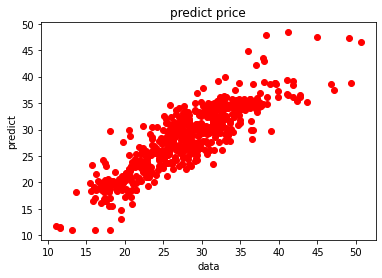

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, pre, c="red")
plt.xlabel("data")
plt.ylabel("predict")
plt.title("predict price")
plt.show()

[Text(279.0, 475.65000000000003, 'Avg_price <= 28.95\nmse = 209.443\nsamples = 3548\nvalue = 25.751'),
 Text(139.5, 339.75, 'Avg_price <= 18.55\nmse = 32.531\nsamples = 2315\nvalue = 17.37'),
 Text(69.75, 203.85000000000002, 'Avg_price <= 13.45\nmse = 10.07\nsamples = 1438\nvalue = 13.865'),
 Text(34.875, 67.94999999999999, '\n  (...)  \n'),
 Text(104.625, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 203.85000000000002, 'Avg_price <= 22.95\nmse = 15.44\nsamples = 877\nvalue = 23.202'),
 Text(174.375, 67.94999999999999, '\n  (...)  \n'),
 Text(244.125, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 339.75, 'Avg_price <= 50.35\nmse = 158.475\nsamples = 1233\nvalue = 41.678'),
 Text(348.75, 203.85000000000002, 'Avg_price <= 39.35\nmse = 36.048\nsamples = 1008\nvalue = 36.788'),
 Text(313.875, 67.94999999999999, '\n  (...)  \n'),
 Text(383.625, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 203.85000000000002, 'Up_price_mean <= 84.6\nmse = 129.499\nsamples = 225\nvalue = 63.17

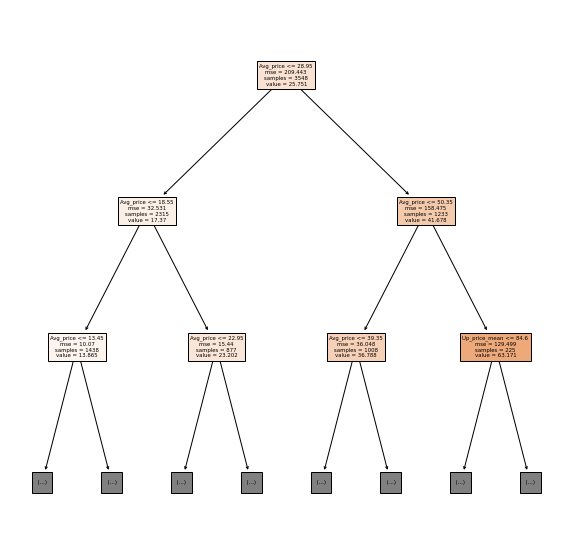

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
features = new_df.drop(['ans_price'], axis=1).columns
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[2], 
          feature_names=features, 
          class_names=['predict_price'],
          max_depth=2,
          filled=True)

In [ ]:
result_df = pd.DataFrame({
    "Name":features,
    "Importance":clf.feature_importances_
}).sort_values(by="Importance", ascending=False)
display(result_df[:10])

,Name,Importance
46,Avg_price,0.832234
44,Mid_price,0.120240
81,Up_price_mean,0.014723
84,Avg_price_mean,0.003698
43,Up_price,0.003148
85,Volume_mean,0.001546
32,Temperature_TXG_mean_of_90days,0.000846
61,Up_price_3days_ago,0.000783
51,Up_price_1days_ago,0.000759
31,Temperature_NTO_mean_of_90days,0.000698


In [ ]:
pd.set_option('display.max_row', None)
result_df

In [ ]:
# # 儲存上面表格的檔案
# result_df.to_csv('/content/drive/MyDrive/AI課程檔案/專題相關/重要性0716(clf0716_ver11).csv')

In [ ]:
# 預測跨模型比較的測試集
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
a, b = np.array(test_df.drop(['ans_price'], axis=1)), np.array(test_df['ans_price'])
pre = clf.predict(a)
result_df = pd.DataFrame({
    "data_price":b,
    "predict_price":pre
})
r2 = r2_score(b, pre)
MSE = mean_squared_error(b, pre)
RMSE = np.sqrt(MSE)
print('r2 score:',r2)
print('mse score:',MSE)
print('rmse:', RMSE)
display(result_df.head())

r2 score: 0.5468974089224645
mse score: 8.750214121964854
rmse: 2.9580760845463145


,data_price,predict_price
0,28.6,29.187050
1,28.1,29.075381
2,24.6,28.024401
3,23.0,27.996722
4,22.8,28.914968


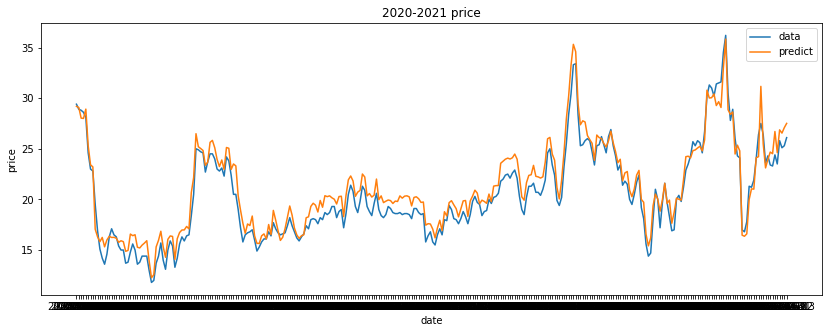

In [ ]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(test_df.index, test_df.Avg_price, label = "data")
plt.plot(test_df.index, pre, label = "predict")
plt.title("2020-2021 price") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label
plt.legend() # 圖例的說明
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32080 missing from current font.
  font.set_

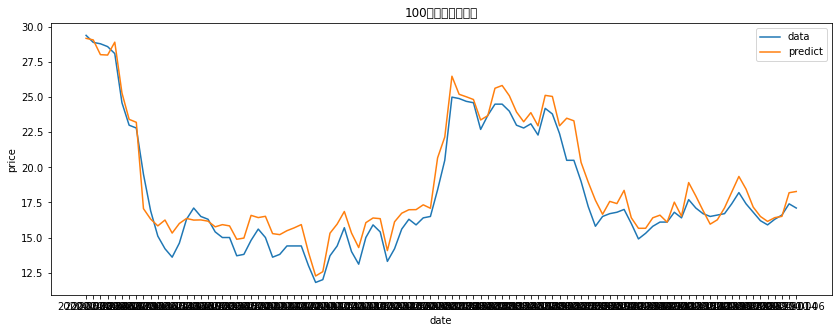

In [ ]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(test_df.index[:100], test_df.Avg_price[:100], label = "data")
plt.plot(test_df.index[:100], pre[:100], label = "predict")
plt.title("100天內的預測結果") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label

plt.legend() # 圖例的說明
plt.show()